# Fit emimTF2N data

EoS: PR

Parameter T dependence: Constant

N (total fitting parameters): 2

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import constant

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('../r125_emimtf2n_full.csv')
data_subset = pd.read_csv('../r125_emimtf2n_subset.csv')
data_extended = pd.read_csv('../r125-emimtf2n-extended.csv')

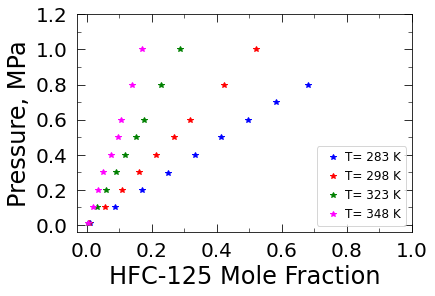

In [3]:
fig, ax = plt.subplots()

ax.plot(data_full["x_R125"][:9],data_full["pressure"][:9]/1e6,"*",color='blue',label="T= 283 K")
ax.plot(data_full["x_R125"][9:18],data_full["pressure"][9:18]/1e6,"*",color='red',label="T= 298 K")
ax.plot(data_full["x_R125"][18:27],data_full["pressure"][18:27]/1e6,"*",color='green',label="T= 323 K")
ax.plot(data_full["x_R125"][27:],data_full["pressure"][27:]/1e6,"*",color='magenta',label="T= 348 K")

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-125 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R125-emimTF2N-data.pdf',bbox_inches='tight')
plt.show()

## Load Configuration + Check DOF + Load Parameters

In [4]:
lhs_results1 = pd.read_csv('../Data/Fits/LHS_Fits/PR_noTdep_LHS.csv',index_col=0)
lhs_results1 = lhs_results1[['sc_param1','sc_param2','SSR']]
lhs_results2 = pd.read_csv('../Data/Fits/LHS_Fits/PR_noTdep_LHS_fromsc_Opt1_102.csv',index_col=0)
lhs_results2 = lhs_results2[['sc_param1','sc_param2','SSR']]
lhs_results3 = pd.read_csv('../Data/Fits/LHS_Fits/PR_noTdep_LHS_fromsc_Opt2_120.csv',index_col=0)
lhs_results3 = lhs_results3[['sc_param1','sc_param2','SSR']]
lhs_results4 = pd.read_csv('Data/Init_Final/LHS_Output/PR_noTdep_LHS_final.csv',index_col=0)
lhs_results4 = lhs_results4[['sc_param1','sc_param2','SSR']]

In [5]:
lhs_results = pd.concat([lhs_results1,lhs_results2,lhs_results3],axis=0).reset_index(drop=True)

In [6]:
lhs_results

,sc_param1,sc_param2,SSR
0,0.365287,-0.100159,NaN
1,-1.640126,-1.117969,NaN
2,-0.474561,-0.621756,NaN
3,-1.795781,0.645068,NaN
4,-0.414749,1.116805,NaN
...,...,...,...
745,-0.055031,0.892747,NaN
746,-0.055031,-0.867972,NaN
747,-0.055031,0.439524,NaN
748,-0.055031,0.513446,NaN


In [7]:
lhs_results.dropna(axis=0)

,sc_param1,sc_param2,SSR
266,-0.157338,-0.002499,6.598708
271,-0.011289,-0.002499,0.186145
283,0.010144,-0.002499,0.186145
300,-0.022485,-0.002499,0.415052
322,-0.077685,-0.002499,6.231187
324,0.007728,-0.002499,0.186145
372,-0.094290,-0.002499,5.287430
375,-0.166299,-0.002499,6.505933
377,-0.005679,-0.002499,0.186145
396,-0.088028,-0.002499,6.623576


In [8]:
lhs_best = lhs_results[lhs_results.SSR == lhs_results.SSR.min()]
lhs_best

,sc_param1,sc_param2,SSR
377,-0.005679,-0.002499,0.186145


In [9]:
sc_param1 = lhs_best.at[377, 'sc_param1']
sc_param2 = lhs_best.at[377, 'sc_param2']

In [10]:
from hfc125_emimtf2n_PR import configuration 

In [11]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [12]:
parameters, obj_value, a = constant(data_subset, configuration, 'R125', 'emimTf2N', "x_R125", "x_emimTf2N", 
        init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
        init_kappa_A_2_1 = sc_param1, init_kappa_A_1_2 = sc_param2, 
        eps = 0.1, scaling_fac = 1e-9 , read=False,
        filename='Data/Fits/Ipopt_Output/PR_noTdep_final.txt')

2022-10-14 12:13:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:34 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:34 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-10-14 12:13:35 [INFO] idaes

In [13]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.1861446556379454


In [14]:
print('Parameters:',parameters)

Parameters: fs.properties.PR_kappa_A[emimTf2N,R125]   -0.034732
fs.properties.PR_kappa_A[R125,emimTf2N]   -0.015915
dtype: float64


In [15]:
params2save = np.zeros(8)
params2save[0] = parameters[1]
params2save[1] = parameters[0]

In [16]:
np.savetxt('Data/Fits/PR_params_noTdep.csv',params2save,delimiter=',')

In [17]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[6.57610544e-05 5.29203579e-06]
 [5.29203579e-06 6.94372420e-07]]


In [18]:
np.savetxt('Data/Covariance/PR_Cov_noTdep.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [ ]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [ ]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['R125','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R125,emimTf2N]']
m.fs.properties.PR_kappa_A['emimTf2N','R125'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R125]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R125_x = np.zeros((len(data_extended)))
P = np.zeros((len(data_extended)))
T = np.zeros((len(data_extended)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_extended)):
    print('i:',i)
    print('Try x_IL:',data_extended["x_emimTf2N"].iloc[i])
    m.fs.liq = data_extended["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_extended["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_extended["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data_extended["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_extended["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_extended["temperature"].iloc[i]))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:

        status = solver.solve(m, tee = False)
        
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = data_extended["temperature"].iloc[i]
        else:
            print('Infeasible Solution')
            R125_x[i] = np.nan
            P[i] = np.nan
            T[i] = data_extended["temperature"].iloc[i]
            
    except ValueError:
        R125_x[i] = np.nan
        P[i] = np.nan
        T[i] = data_extended["temperature"].iloc[i]
        print('Solver Error')

In [ ]:
fitted_data = pd.DataFrame(data=[R125_x,P/1e6,T])
fitted_data = fitted_data.T
fitted_data.columns = ['R125_x','P, MPa','T, K']
fitted_data.to_csv('Data/Fits/PR_FittedData_noTdep.csv')

In [ ]:
plt.plot(fitted_data.where(fitted_data['T, K']==283.1)['R125_x'],fitted_data.where(fitted_data['T, K']==283.1)['P, MPa'],"b-",label='T=283 K')
plt.plot(fitted_data.where(fitted_data['T, K']==298.1)['R125_x'],fitted_data.where(fitted_data['T, K']==298.1)['P, MPa'],"r-",label='T=298 K')
plt.plot(fitted_data.where(fitted_data['T, K']==323.1)['R125_x'],fitted_data.where(fitted_data['T, K']==323.1)['P, MPa'],"c-",label='T=323 K')
plt.plot(fitted_data.where(fitted_data['T, K']==348.1)['R125_x'],fitted_data.where(fitted_data['T, K']==348.1)['P, MPa'],"m-",label='T=348 K')
plt.plot(data_full["x_R125"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors of Covariance

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals >> 0, their eigvecs indicate directions of un-identifiability.

In [ ]:
eigvals, eigvecs = np.linalg.eig(cov)

In [ ]:
eigvals

In [ ]:
eigvecs

In [ ]:
np.savetxt('Data/EigenAnalysis/PR_vals_noTdep.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_noTdep.csv',eigvecs,delimiter=',')

In [ ]:
FIM = np.linalg.inv(cov) 

#A_opt
FIM_trace = np.trace(FIM)
cov_trace = np.trace(cov)

#D_opt
FIM_det = np.linalg.det(FIM)

#E_opt
eigvals_FIM, eigvecs_FIM = np.linalg.eig(FIM)
eigvals_FIM_min = eigvals_FIM.min()
eigvals_FIM_max = eigvals_FIM.max()

np.savetxt('Data/EigenAnalysis/PR_FIMtrdet_noTdep.csv',[cov_trace,FIM_trace,FIM_det,eigvals_FIM_min,eigvals_FIM_max])
np.savetxt('Data/EigenAnalysis/PR_FIMvals_noTdep.csv',eigvals_FIM,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_FIMvecs_noTdep.csv',eigvecs_FIM,delimiter=',')

## AIC Value

See: https://doi.org/10.1080/21642583.2018.1496042

AIC(k) = Nln(MSE(k))+2k

N: number of data points

MSE(k): mean squared error of the model with k parameters

k: number of parameters

MSE(k) = SSE(k)/N

SSE: sum of squared error of the model with k parameters

In [ ]:
#number of datapoints
N = len(data_subset)
#MSE(k)
MSE = obj_value/N
#number of parameters
k = 2

In [ ]:
AIC = N*np.log(MSE) + 2*k
AIC

In [ ]:
AIC_data = pd.DataFrame(data=[N,MSE,k,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['N','MSE','k','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_noTdep.csv')